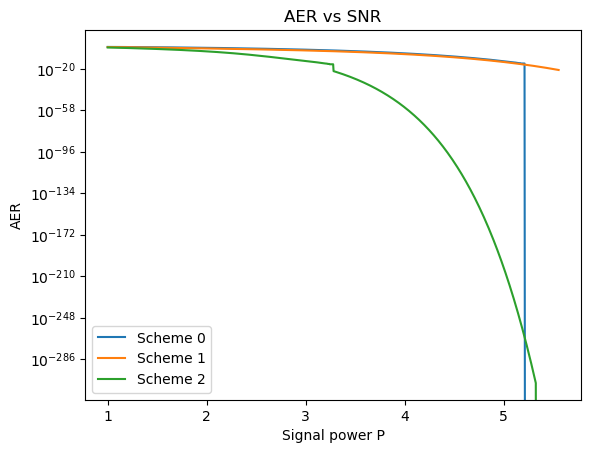

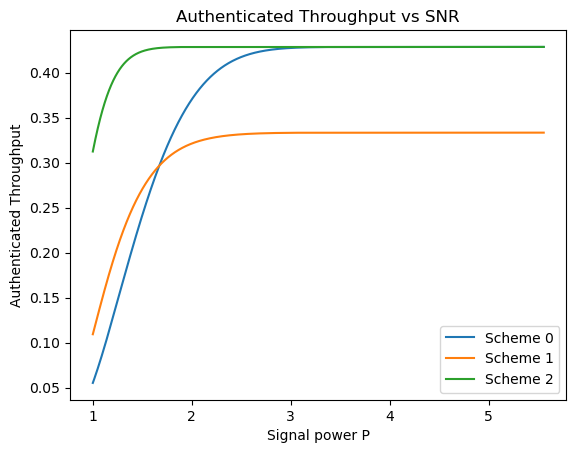

In [102]:
import numpy as np
from scipy.special import erfc

# Q-function using erfc for Gaussian distribution
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

# Calculate gamma values for tag and message based on alpha, signal power P, and noise power sigma_n
def calculate_gamma(alpha, P, sigma_n):
    gamma_t = (alpha * P) / ((1 - alpha) * P + sigma_n)
    gamma_m = ((1 - alpha) * P) / (alpha * P + sigma_n)
    return gamma_t, gamma_m

# Calculate Bit Error Rate (BER) p_t and p_m based on gamma_t and gamma_m
def calculate_p(gamma):
    return Q(np.sqrt(2 * gamma))

# Define C' and C'' based on p_t and p_m using the channel capacity formula
def calculate_C(p):
    return 1 + p * np.log2(p) + (1 - p) * np.log2(1 - p) 

# Calculating Pe for tag and message lengths based on the provided formulas
def calculate_Pe(R, p, C, length, y=1):
    if y == 1:
        return Q(np.sqrt(length / (p * (1 - p))) * ((C - R) / np.log2((1 - p) / p)))
    else:
        return Q(np.sqrt(y * length / (p * (1 - p))) * ((C - R*(t/y*m)) / np.log2((1 - p) / p)))

# Calculate AER based on the provided formula
def calculate_AER(Pe_m_prime, Pe_t_prime, Pe_t, x, y):
    term1 = Pe_m_prime
    term2 = (1 - (1 - Pe_m_prime)**(y-1) * (1 - Pe_t_prime))
    term3 = (1 - (1 - Pe_m_prime)**(x-1) * (1 - Pe_t))
    AER = term1 + term2 * term3 * (1 - Pe_m_prime)
    return AER

# Arbitrary values for parameters
P = 10  # Signal power
sigma_ns = np.linspace(1.8,10,2000) # Noise power
alpha_scheme_1 = 0  # Alpha for scheme 1
alpha_scheme_2 = 0.01  # Alpha for scheme 2
R = 0.8 # Transmission rate
t = 50/R  # Length of the tag
m = 10/R  # Length of the message
x = 3  # Arbitrary parameter
y = 6  # Arbitrary parameter


AER = {"AER_scheme_0":[], "AER_scheme_1":[], "AER_scheme_2":[]}
for sigma_n in sigma_ns:
    # Scheme 0 calculations
    gamma_t_0, gamma_m_0 = calculate_gamma(0, P, sigma_n)
    # print("gamma_t_0:", gamma_t_0, "gamma_m_0:", gamma_m_0)
    p_0 = calculate_p(gamma_m_0)
    C_0 = calculate_C(p_0)
    # print("p_0:", p_0, "C_0:", C_0)
    Pe_t_0 = calculate_Pe(R, p_0, C_0, t)
    Pe_m_0 = calculate_Pe(R, p_0, C_0, m)
    # print("Pe_m:", Pe_m_0, "Pe_t:", Pe_t_0)

    AER_scheme_0 = 1-(1-Pe_t_0)*((1-Pe_m_0)**(y-1))

    # Scheme 1 calculations
    gamma_t_1, gamma_m_1 = calculate_gamma(alpha_scheme_1, P, sigma_n)
    # print("gamma_t_1:", gamma_t_1, "gamma_m_1:", gamma_m_1)
    p_1 = calculate_p(gamma_m_1)
    C_1 = calculate_C(p_1)
    # print("C1:", C_1)
    Pe_t_1 = calculate_Pe(R, p_1, C_1, t)
    Pe_m_1 = calculate_Pe(R, p_1, C_1, m)
    # print("Pe_t:", Pe_t_1)
    # print("Pe_m:", Pe_m_1)
    AER_scheme_1 = calculate_AER(Pe_m_1, Pe_t_1, Pe_t_1, x, y)

    # Scheme 2 calculations
    gamma_t_2, gamma_m_2 = calculate_gamma(alpha_scheme_2, P*(y*m + t)/(y*m), sigma_n)
    # print("P*(y*m + t)/(y*m):", p*(y*m + t)/(y*m), "y*m:", y*m, "t:", t)
    # print("gamma_t_2:", gamma_t_2, "gamma_m_2:", gamma_m_2)
    p_t_2 = calculate_p(gamma_t_2)
    p_m_2 = calculate_p(gamma_m_2)
    C_prime_2 = calculate_C(p_t_2)
    C_double_prime_2 = calculate_C(p_m_2)
    # print("C_prime_2:", C_prime_2)
    # print("C_double_prime_2:", C_double_prime_2)
    Pe_t_prime_2 = calculate_Pe(R, p_t_2, C_prime_2, t, y=y)
    Pe_m_prime_2 = calculate_Pe(R, p_m_2, C_double_prime_2, m)
    AER_scheme_2 = calculate_AER(Pe_m_prime_2, Pe_t_prime_2, Pe_t_1, x, y)

    AER["AER_scheme_0"].append(AER_scheme_0)
    AER["AER_scheme_1"].append(AER_scheme_1)
    AER["AER_scheme_2"].append(AER_scheme_2)

import matplotlib.pyplot as plt
plt.plot(P/sigma_ns, AER["AER_scheme_0"], label="Scheme 0")
plt.plot(P/sigma_ns, AER["AER_scheme_1"], label="Scheme 1")
plt.plot(P/sigma_ns, AER["AER_scheme_2"], label="Scheme 2")
plt.xlabel("Signal power P")
plt.ylabel("AER")
#log scale
plt.yscale("log")
# plt.xscale("log")
plt.title("AER vs SNR")
plt.legend()
plt.show()


# plot the authenticated throughput
# authenticated throughput = (1 - AER) * R
authenticated_throughput = {"scheme_0":[], "scheme_1":[], "scheme_2":[]}
for i in range(len(sigma_ns)):
    authenticated_throughput["scheme_0"].append((1 - AER["AER_scheme_0"][i]) * R * x*y/(x*y + x))
    authenticated_throughput["scheme_1"].append((1 - AER["AER_scheme_1"][i]) * R * x*y/(x*y + (x+y)))
    authenticated_throughput["scheme_2"].append((1 - AER["AER_scheme_2"][i]) * R * x*y/(x*y + x))


plt.plot(P/sigma_ns, authenticated_throughput["scheme_0"], label="Scheme 0")
plt.plot(P/sigma_ns, authenticated_throughput["scheme_1"], label="Scheme 1")
plt.plot(P/sigma_ns, authenticated_throughput["scheme_2"], label="Scheme 2")
plt.xlabel("Signal power P")
plt.ylabel("Authenticated Throughput")
plt.title("Authenticated Throughput vs SNR")
plt.legend()
plt.show()



In [35]:
print(AER)

{'AER_scheme_0': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.